# AD, QLattice, Ubuntu, 25-11-21

In [1]:
from platform import python_version
print(python_version())

3.8.10


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import feyn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from functions import modsum, model_features_chart, crossvalidation_as_framework

feyn._qlattice._USE_V2_API=True

In [3]:
feyn.__version__

'2.1.2'

In [4]:
# Load the data
data = pd.read_csv("../data/ad_omics.csv")

In [5]:
# Define the semantic types
stypes = {}
for f in data.columns:
    if data[f].dtype =='object':
        stypes[f] = 'c'
        
# Set random seed for reproducibility
random_seed = 42

In [6]:
target = "_clinical AD diagnosis"

## In depth modelling

In [7]:
projectname = 'ad_ms_proteomics_'
pathname = '../figures/'

### Get the test data

In [8]:
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

In [9]:
epochs = 50
criterion = 'bic'
max_complexity = 5
random_seed = 42
sw = np.where(train_val[target] == 1, np.sum(train_val[target] == 0)/sum(train_val[target]), 1)

In [10]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = max_complexity,
                         sample_weights=sw)

## Model summary

In [11]:
df_summary = modsum(models_single, train_val, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]

In [12]:
df_summary

,N. Features,Functional form,BIC,Loss,AUC Train
0,3,logreg(LILRA2 + MAPT + age at CSF collection),46.11,0.168468,0.98
1,3,logreg(IGKV2D-29 + LILRA2 + MAPT),49.11,0.182253,0.98
2,3,logreg(FAM174A + IGLV4-69 + MAPT),49.28,0.183027,0.97
3,3,logreg(MAPT*(AJAP1 + SERPINE2.1)),49.45,0.162273,0.97
4,3,logreg(ENOPH1 + GPC1 + MAPT),51.42,0.192819,0.97
5,3,logreg(GPC1 + MAPT + age at CSF collection),52.27,0.196747,0.98
6,3,logreg(ENDOD1 + MAPT + PPIA),54.08,0.205037,0.97
7,3,logreg(GPC1 + MAPT + SERPINE2.1),54.86,0.208604,0.97
8,2,logreg(IGLV4-69 + MAPT),54.95,0.230524,0.97
9,3,logreg(MAPT + NXPH3 + SPINT2),57.0,0.218450,0.97


In [13]:
df_summary.to_csv("AD_summary_models.csv")

## Best model from autorun (BIC criterion)

In [14]:
best_model = models_single[0]

In [43]:
best_model.plot(train_val,test, filename=pathname+projectname+'bestmodel_summary'+'.html')

'/Users/miqueltrianaiglesias/repos/qlattice-clinical-omics-paper/figures/ad_ms_proteomics_bestmodel_summary.html'

# Plot feature conservation across models with dirac

In [16]:
model_features_chart(train_val, models_single, metric="roc_auc_score")

,roc_auc_score,MAPT,GPC1,SERPINE2.1,_age at CSF collection,LILRA2,IGLV4-69,NXPH3,AJAP1,ENOPH1,IGKV2D-29,ENDOD1,PPIA,FAM174A,SPINT2
Model#,,,,,,,,,,,,,,,
0,0.982051,True,False,False,True,True,False,False,False,False,False,False,False,False,False
1,0.976190,True,False,False,False,True,False,False,False,False,True,False,False,False,False
2,0.974359,True,False,False,False,False,True,False,False,False,False,False,False,True,False
3,0.972527,True,False,True,False,False,False,False,True,False,False,False,False,False,False
4,0.974725,True,True,False,False,False,False,False,False,True,False,False,False,False,False
5,0.980586,True,True,False,True,False,False,False,False,False,False,False,False,False,False
6,0.973260,True,False,False,False,False,False,False,False,False,False,True,True,False,False
7,0.969963,True,True,True,False,False,False,False,False,False,False,False,False,False,False
8,0.970330,True,False,False,False,False,True,False,False,False,False,False,False,False,False


In [17]:
#excello = model_features_chart(test, models_single, metric="roc_auc_score")

In [18]:
#excello.to_excel('AD_QLAttice_Ubuntu_features_chart_autorun_best_251121.xlsx')

# Exploring model 0 further

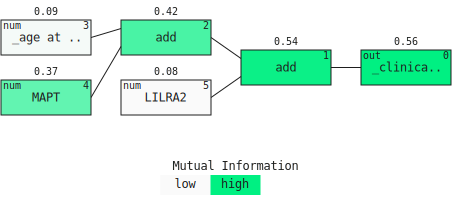

In [45]:
models_single[0].plot_signal(train_val,corr_func='mutual_information',
                             filename=pathname+projectname+'bestmodel_signal_MI'+'.pdf')

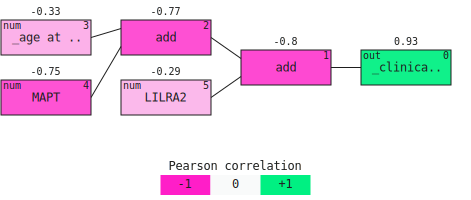

In [44]:
models_single[0].plot_signal(train_val, corr_func='pearson',filename=pathname+projectname+'bestmodel_signal_PEARSON'+'.pdf')

In [22]:
sympy_model = models_single[0].sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(98000000000000.0*exp(0.000673*LILRA2 - 0.00086*MAPT - 0.263*age at CSF collection) + 1)

In [23]:
models_single[0].inputs[-1]

'_age at CSF collection'

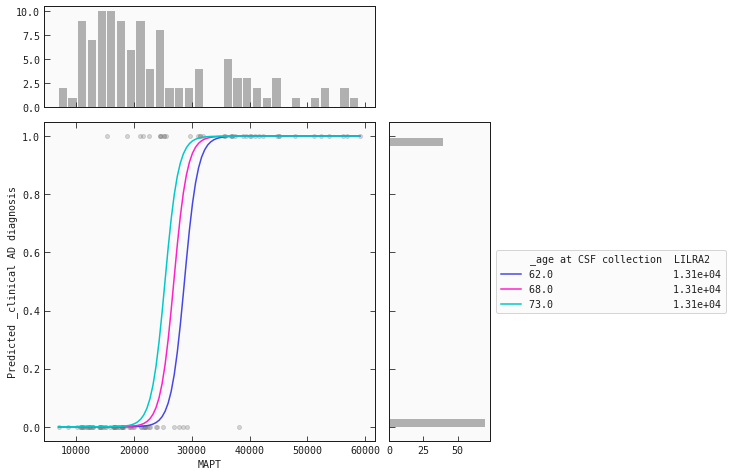

In [46]:
show_quantiles = '_age at CSF collection'
fixed = {}
fixed[show_quantiles] = [
    train_val[show_quantiles].quantile(q=0.25),
    train_val[show_quantiles].quantile(q=0.5),
    train_val[show_quantiles].quantile(q=0.75)
]

best_model.plot_response_1d(train_val, by = 'MAPT', input_constraints=fixed, 
                            filename=pathname+projectname+'bestmodel_response1d_age'+'.pdf')

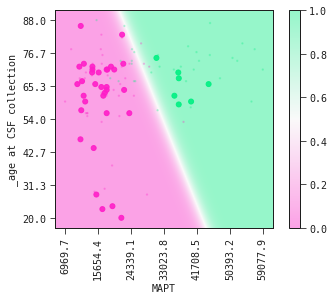

In [25]:
models_single[0].plot_response_2d(train_val, fixed={"LILRA2":15000})

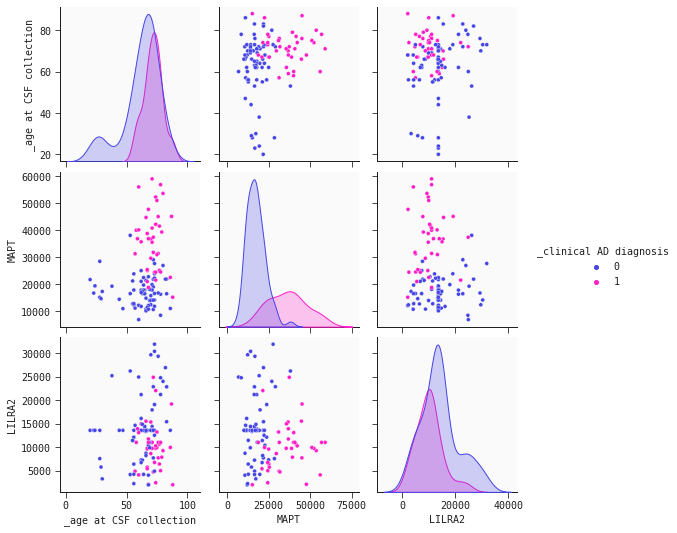

In [26]:
features_data = train_val[['_age at CSF collection', 'MAPT','LILRA2', '_clinical AD diagnosis']]
sns.pairplot(features_data, hue = target)

# Cross-validation as a framework

In [27]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = max_complexity)

In [28]:
# average performance of first 10 models
results.roc_auc_val.mean(), results.accuracy_val.mean()

(0.9415526506899056, 0.8666666666666666)

In [32]:
# average performance of first model
results.groupby("fold").first().roc_auc_val.mean(), results.groupby("fold").first().accuracy_val.mean()

(0.938162672476398, 0.8986772486772487)

In [33]:
results.groupby("fold").first().roc_auc_val.std(), results.groupby("fold").first().accuracy_val.std()

(0.04847411595361505, 0.06784566772823196)

In [34]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(IGLV4-69 + 1/MAPT),31.111716,36.494412,0.992674,0.944954,0.883333,0.785714,0.844130,0.625000,"add(""IGLV4-69"", inverse(""MAPT""))"
1,logreg(CRP + LILRA2 + MAPT),40.570347,45.953043,0.981685,0.935780,0.988889,0.892857,0.979899,0.800000,"add(""MAPT"", add(""LILRA2"", ""CRP""))"
2,logreg(CDH13 + IGLV4-69*MAPT),46.439063,54.540504,0.977857,0.918182,0.895062,0.962963,0.925897,0.695652,"add(multiply(""IGLV4-69"", ""MAPT""), ""CDH13"")"
3,logreg(LILRA2 + MAPT**2),48.913534,54.314494,0.969303,0.918182,0.982353,0.925926,0.972020,0.606061,"add(squared(""MAPT""), ""LILRA2"")"
4,logreg(IGKV2D-29 + LILRA2 + MAPT),48.611043,54.012004,0.971831,0.936364,0.941176,0.925926,0.752558,0.606061,"add(""MAPT"", add(""IGKV2D-29"", ""LILRA2""))"


In [35]:
results3 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = 3)

In [37]:
results3.groupby("fold").first().roc_auc_val.mean(), results3.groupby("fold").first().accuracy_val.mean()

(0.9172549019607844, 0.8624338624338623)

In [38]:
results3.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(MAPT**2),42.728479,45.419827,0.982784,0.944954,0.850000,0.750000,0.795200,0.666667,"squared(""MAPT"")"
1,logreg(FCGBP*MAPT),48.663686,54.046382,0.962637,0.917431,0.883333,0.821429,0.853471,0.689655,"multiply(""FCGBP"", ""MAPT"")"
2,logreg(CRP + MAPT),57.975906,60.676386,0.959286,0.909091,1.000000,0.925926,1.000000,0.666667,"add(""CRP"", ""MAPT"")"
3,logreg(MAPT*PRSS3),58.561139,63.962100,0.964247,0.890909,0.941176,0.888889,0.931887,0.625000,"multiply(""MAPT"", ""PRSS3"")"
4,logreg(LILRA2 + MAPT),53.130879,55.831360,0.962802,0.918182,0.911765,0.925926,0.723353,0.645161,"add(""LILRA2"", ""MAPT"")"
